In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
!pip install scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re

In [2]:

train_df = pd.read_csv('new1_cyber_train.csv')
test_df = pd.read_csv('new1_cyber_test.csv')
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Nadam
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set TensorFlow logging level to only display errors
import tensorflow as tf

# Disable TensorFlow deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Apply stemming
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)


In [3]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Assuming you have train_df and test_df dataframes with 'text' and 'label' columns
# Tokenize text data
max_length = 128  # Set maximum sequence length
train_encodings = tokenizer(train_df['text'].tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='tf')
test_encodings = tokenizer(test_df['text'].tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='tf')

# Convert labels to numerical format
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
test_labels = label_encoder.transform(test_df['label'])

# Define input layers for BERT embeddings
input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Obtain BERT embeddings
bert_outputs = bert_model(input_ids, attention_mask=attention_mask)[0]

# Define Bi-LSTM layers on top of BERT embeddings
bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(bert_outputs)
dropout = Dropout(0.5)(bi_lstm)  # Adjust dropout rate

# Pooling layer to get a fixed-size output
pooling = tf.keras.layers.GlobalMaxPooling1D()(dropout)

# Output layer
output = Dense(1, activation='sigmoid')(pooling)

# Create a combined model
combined_model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the combined model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Use Adam optimizer with a lower learning rate
loss = 'binary_crossentropy'
metric = 'accuracy'
combined_model.compile(optimizer=opt, loss=loss, metrics=[metric])

# Train the combined model with increased epochs and learning rate scheduling
history = combined_model.fit(
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    train_labels,
    epochs=5,  # Increase the number of epochs
    batch_size=32,
    validation_split=0.1,
)




Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
26/26 [==============================] - 275s 9s/step - loss: 0.6044 - accuracy: 0.6732 - val_loss: 0.5144 - val_accuracy: 0.7253
Epoch 2/5
26/26 [==============================] - 234s 9s/step - loss: 0.3290 - accuracy: 0.8681 - val_loss: 0.4347 - val_accuracy: 0.7912
Epoch 3/5
26/26 [==============================] - 232s 9s/step - loss: 0.1342 - accuracy: 0.9531 - val_loss: 0.4035 - val_accuracy: 0.8571
Epoch 4/5
26/26 [==============================] - 232s 9s/step - loss: 0.1669 - accuracy: 0.9445 - val_loss: 0.3340 - val_accuracy: 0.8901
Epoch 5/5
26/26 [==============================] - 232s 9s/step - loss: 0.0756 - accuracy: 0.9716 - val_loss: 0.3371 - val_accuracy: 0.8901


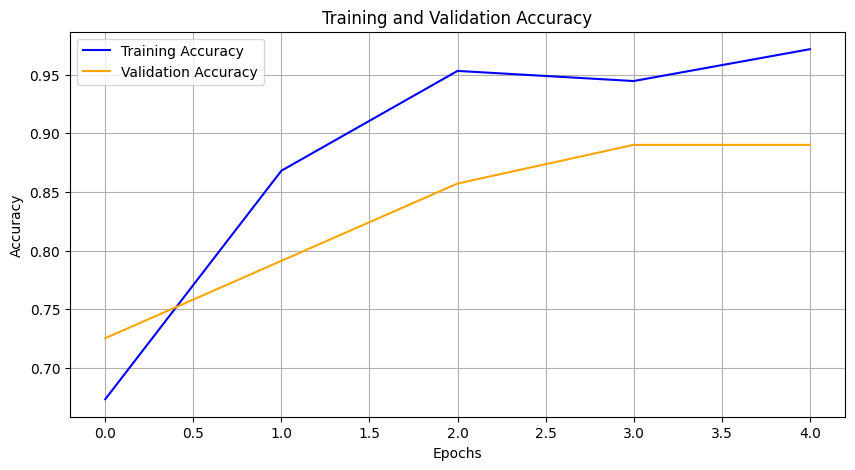

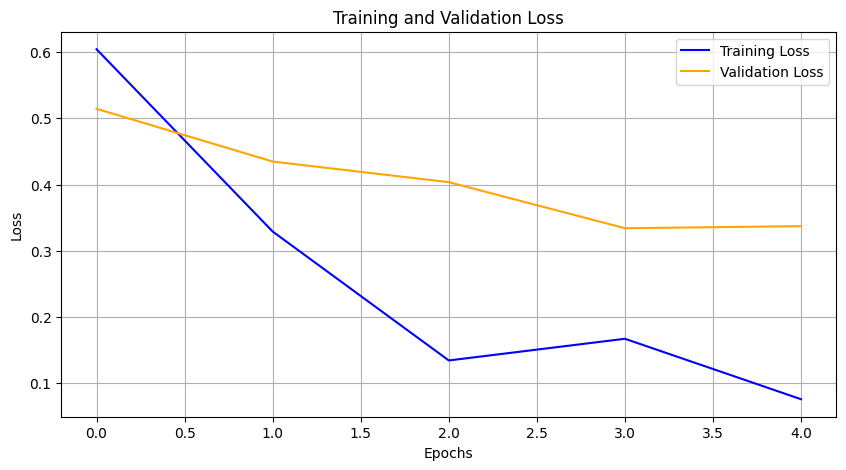

In [4]:
import matplotlib.pyplot as plt

# Get training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Reset the shape of test_encodings
max_length = 128  # Set maximum sequence length consistently
test_input_ids = tf.keras.preprocessing.sequence.pad_sequences(test_encodings['input_ids'], maxlen=max_length, padding='post')
test_attention_mask = tf.keras.preprocessing.sequence.pad_sequences(test_encodings['attention_mask'], maxlen=max_length, padding='post')

# Make predictions on the test data
predictions = combined_model.predict({'input_ids': test_input_ids, 'attention_mask': test_attention_mask})

# Convert predictions to labels
predicted_labels = (predictions > 0.5).astype(int)  # Assuming binary classification with threshold 0.5

# Decode labels if necessary
predicted_labels = label_encoder.inverse_transform(predicted_labels.flatten())

# Evaluate the predictions
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

# Generate classification report
print(classification_report(test_labels, predicted_labels))

8/8 [==============================] - 22s 2s/step
Accuracy: 0.8805309734513275
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       113
           1       0.91      0.84      0.88       113

    accuracy                           0.88       226
   macro avg       0.88      0.88      0.88       226
weighted avg       0.88      0.88      0.88       226

